In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4
use_sin = True

## Let's load the data files

In [5]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [6]:
random.seed(8392)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['xy_track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df['rz_track'] = df[['r','tz']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000028-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,xy_track,rz_track
0,4503599962914816,936748859932016652,32.418297,-1.918269,5.118978,0.109697,4.186113,-0.237950,0.660914,4.245955,0,0,0,0,0,1.0,32.475002,-0.059103,"(32.47500150272427, -0.059103494687617275)","(32.47500150272427, 5.11897802)"
1,4503599929360384,936748859932016665,31.773275,8.699886,-17.026638,0.123715,5.058879,1.395419,-2.712349,5.908253,0,0,0,0,0,1.0,32.942815,0.267261,"(32.942814871002874, 0.2672608815600021)","(32.942814871002874, -17.026638)"
2,4503599946137600,936748859932016665,26.298058,18.426424,-7.241706,0.109830,3.668614,2.582266,-1.011750,4.600177,0,0,0,0,0,1.0,32.111072,0.611180,"(32.11107184384685, 0.6111796695439595)","(32.11107184384685, -7.24170589)"
3,4503600046800896,936748859932016666,29.145838,13.367415,4.746732,0.108233,2.110011,0.978309,0.344294,2.353495,0,0,0,0,0,1.0,32.065053,0.430015,"(32.06505349348517, 0.4300147814853668)","(32.06505349348517, 4.74673176)"
4,4503599862251520,936748859932016679,-23.740015,-21.990231,2.910834,0.108391,-4.764247,-4.426317,0.584967,6.530213,0,0,0,0,0,1.0,32.359829,-2.394439,"(32.359829326518415, -2.394439008463587)","(32.359829326518415, 2.9108336)"


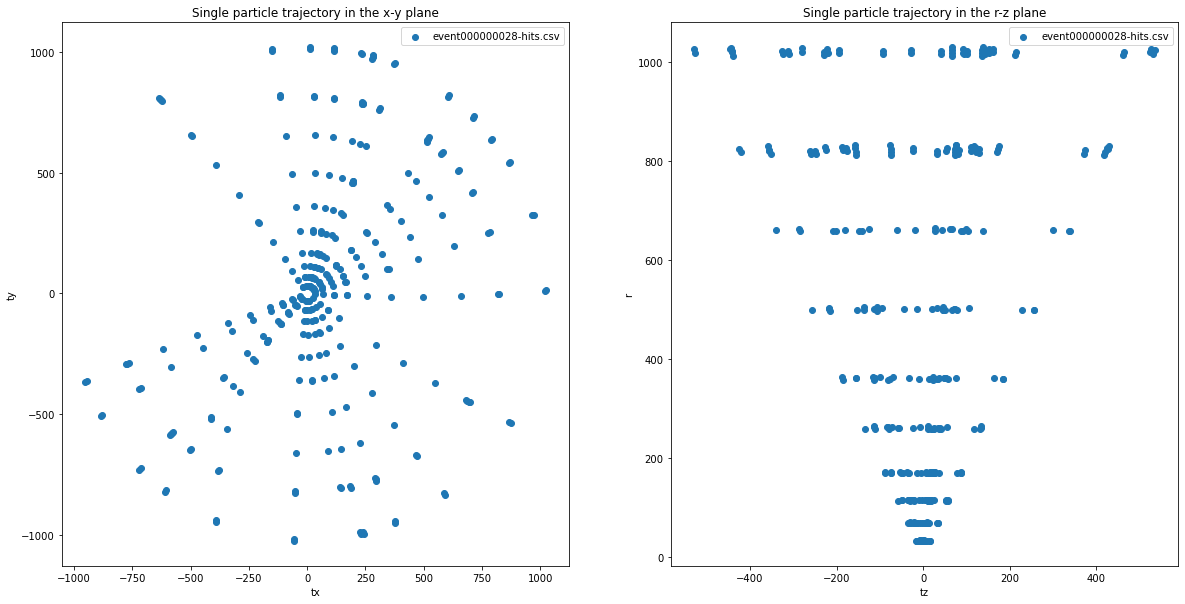

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])
ax1.set_xlabel('tx')
ax1.set_ylabel('ty')
ax1.set_title('Single particle trajectory in the x-y plane')
ax1.legend(loc='best')

ax2.scatter(x=df['tz'], y=df['r'], label=hit_files[random_event])
ax2.set_xlabel('tz')
ax2.set_ylabel('r')
ax2.set_title('Single particle trajectory in the r-z plane')
ax2.legend(loc='best')

plt.show()

Let's define here the bin size and the range of search.

In [8]:
all_xy_tracks = list(df['xy_track'])
all_rz_tracks = list(df['rz_track'])

xy_x_range = np.arange(0, np.pi, 0.01)
rz_x_range = np.arange(-1, 1, 0.01)

Let's plot the tracks in the Hough Space.

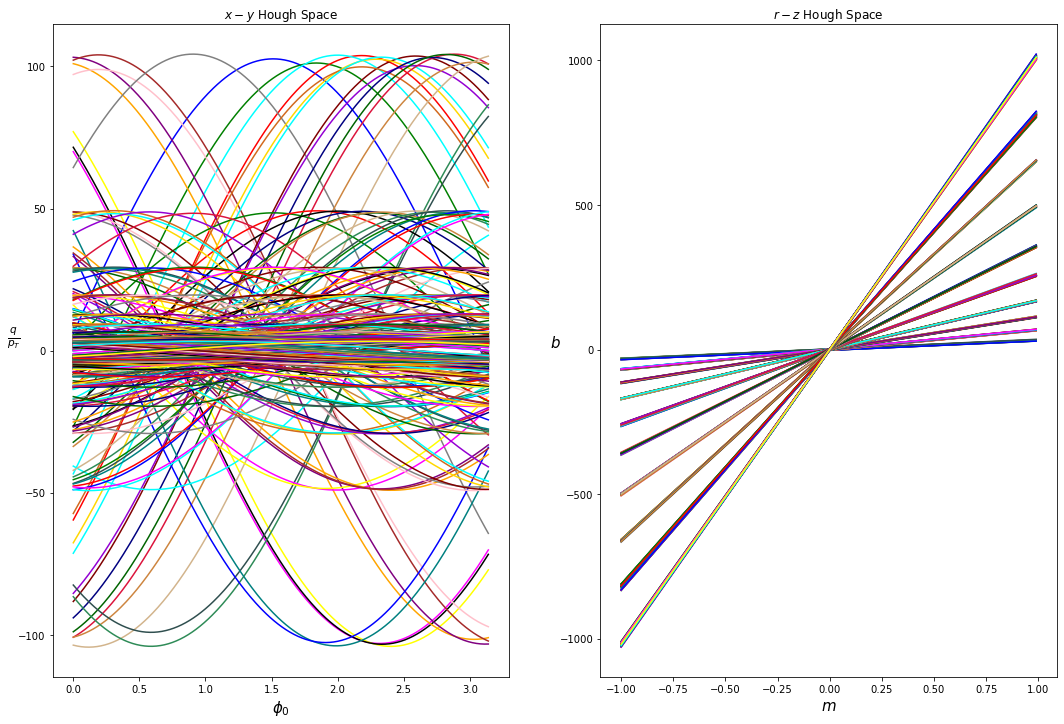

In [9]:
# min_y, max_y = float('inf'), float('-inf')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# plot xy tracks
for idx, track in enumerate(all_xy_tracks):
    r, phi = track
    ys = np.sin(xy_x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    ax1.plot(xy_x_range, ys, color=colors[idx % len(colors)])

ax1.set_xlabel('$\phi_0$', fontsize=15)
h = ax1.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
ax1.set_title('$x-y$ Hough Space')


# plot rz tracks
for idx, track in enumerate(all_xy_tracks):
    r, z = track
    ys = r * rz_x_range + z
    ax2.plot(rz_x_range, ys, color=colors[idx % len(colors)])

ax2.set_xlabel('$m$', fontsize=15)
h = ax2.set_ylabel('$b$', fontsize=15)
h.set_rotation(0)
ax2.set_title('$r-z$ Hough Space')
    
plt.show()

### First we will run each transformation to see how it performs on its own and then we will compare them with their combination.

In [10]:
# first define the hyperparameters of the transforms
xy_hyperparams = {
    'bin-size': (0.0025, 0.05),
    'phi-range': (0, np.pi),
    'qpt-range': (-200, 200),
    'minimum-hits-per-bin': 10,
    'use-sin': True
}

rz_hyperparams = {
    'bin-size': (0.005, 0.1),
    'r-range': (-1, 1),
    'z-range': (-1000, 1000),
    'minimum-hits-per-bin': 12
}

In [11]:
from notebook2_utils import xy_pipeline, compute_all_intersections, rz_pipeline

_, xy_est_tracks_to_hits = xy_pipeline(all_xy_tracks, xy_hyperparams)

rz_intersections = compute_all_intersections(all_rz_tracks)
rz_est_tracks_to_hits = rz_pipeline(all_rz_tracks, rz_intersections, rz_hyperparams)

len(xy_est_tracks_to_hits), len(rz_est_tracks_to_hits)

(58, 42)

In [12]:
from metrics import efficiency_rate, fake_rate, duplicate_rate

df['track'] = df['xy_track']
xy_eff = efficiency_rate(xy_est_tracks_to_hits.values(), df)
xy_fak = fake_rate(xy_est_tracks_to_hits.values(), df)
xy_dup = duplicate_rate(xy_est_tracks_to_hits.values(), df)

df['track'] = df['rz_track']
rz_eff = efficiency_rate(rz_est_tracks_to_hits.values(), df)
rz_fak = fake_rate(rz_est_tracks_to_hits.values(), df)
rz_dup = duplicate_rate(rz_est_tracks_to_hits.values(), df)

In [13]:
print(f'xy-transform Efficiency Rate:\t {xy_eff}')
print(f'xy-transform Fake Rate:\t\t {xy_fak}')
print(f'xy-transform Duplicate Rate:\t {xy_dup}')
print()
print(f'rz-transform Efficiency Rate:\t {rz_eff}')
print(f'rz-transform Fake Rate:\t\t {rz_fak}')
print(f'rz-transform Duplicate Rate:\t {rz_dup}')

xy-transform Efficiency Rate:	 0.9583333333333334
xy-transform Fake Rate:		 0.08620689655172414
xy-transform Duplicate Rate:	 0.603448275862069

rz-transform Efficiency Rate:	 0.9166666666666666
rz-transform Fake Rate:		 0.0
rz-transform Duplicate Rate:	 0.47619047619047616


## Combination 1:

    a. Run the x-y transform.
    b. Remove the hits found.
    c. Run the r-z transform.
    d. Aggregate results.

In [14]:
from notebook2_utils import combine_transforms_1

comb_eff, comb_fake, comb_dup = combine_transforms_1(df, xy_hyperparams, rz_hyperparams)
print(f'Combined-transform Efficiency Rate:\t {comb_eff}')
print(f'Combined-transform Fake Rate:\t\t {comb_fake}')
print(f'Combined-transform Duplicate Rate:\t {comb_dup}')

Combined-transform Efficiency Rate:	 1.0
Combined-transform Fake Rate:		 0.0847457627118644
Combined-transform Duplicate Rate:	 0.5932203389830508


Now let's try the other type of combination.

## Combination 2:

    a. Run the x-y and r-z transforms.
    b. Consider tracks that have common hits.

In [15]:
from notebook2_utils import combine_transforms_2

xy_rates, rz_rates = combine_transforms_2(df, xy_hyperparams, rz_hyperparams)
xy_eff, xy_fake, xy_dup = xy_rates
rz_eff, rz_fake, rz_dup = rz_rates

print(f'Combined-xy-transform Efficiency Rate:\t {xy_eff}')
print(f'Combined-xy-transform Fake Rate:\t {xy_fak}')
print(f'Combined-xy-transform Duplicate Rate:\t {xy_dup}')
print()
print(f'Combined-rz-transform Efficiency Rate:\t {rz_eff}')
print(f'Combined-rz-transform Fake Rate:\t {rz_fak}')
print(f'Combined-rz-transform Duplicate Rate:\t {rz_dup}')

Combined-xy-transform Efficiency Rate:	 0.875
Combined-xy-transform Fake Rate:	 0.08620689655172414
Combined-xy-transform Duplicate Rate:	 0.5116279069767442

Combined-rz-transform Efficiency Rate:	 0.875
Combined-rz-transform Fake Rate:	 0.0
Combined-rz-transform Duplicate Rate:	 0.4473684210526315


## Combination 3:

    a. Run the x-y and r-z transforms.
    b. Consider tracks that have common hits and extend them with extra hits from the other transform.

In [16]:
from notebook2_utils import combine_transforms_3

xy_rates, rz_rates = combine_transforms_3(df, xy_hyperparams, rz_hyperparams)
xy_eff, xy_fake, xy_dup = xy_rates
rz_eff, rz_fake, rz_dup = rz_rates

print(f'Combined-xy-transform Efficiency Rate:\t {xy_eff}')
print(f'Combined-xy-transform Fake Rate:\t {xy_fak}')
print(f'Combined-xy-transform Duplicate Rate:\t {xy_dup}')
print()
print(f'Combined-rz-transform Efficiency Rate:\t {rz_eff}')
print(f'Combined-rz-transform Fake Rate:\t {rz_fak}')
print(f'Combined-rz-transform Duplicate Rate:\t {rz_dup}')

Combined-xy-transform Efficiency Rate:	 0.8333333333333334
Combined-xy-transform Fake Rate:	 0.08620689655172414
Combined-xy-transform Duplicate Rate:	 0.5348837209302326

Combined-rz-transform Efficiency Rate:	 0.875
Combined-rz-transform Fake Rate:	 0.0
Combined-rz-transform Duplicate Rate:	 0.4473684210526315
